# Feature engineering on extracted Pull Requests data


## What we did previously

In the previous step, we collected data from a Github repository of choice and store them on S3 storage

## In this step

In this notebook we will walk through how to start analyzing the PR data collected from a Github repository.

We explore the various fields in the PR dataset and the features that we can derive from them in order to frame an a Machine Learning where we predict the time taken to merge a PR.

In [1]:
import os
import re
import gzip
import json
import boto3
import pathlib
import datetime
from tqdm import tqdm
from io import BytesIO
from pathlib import Path
from functools import partial
from collections import Counter
from github import Github

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import STOPWORDS

from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import chi2
from sklearn.feature_selection import mutual_info_classif, f_classif

from dotenv import load_dotenv, find_dotenv
import ceph_comm

In [2]:
sns.set(rc={"figure.figsize": (20, 10)})
load_dotenv(find_dotenv(), override=True)

True

In [3]:
## CEPH Bucket variables
## Create a .env file on your local with the correct configs,

ORG = os.getenv("GITHUB_ORG")
REPO = os.getenv("GITHUB_REPO")

## S3 bucket credentials
s3_endpoint_url = os.getenv("S3_ENDPOINT_URL")
s3_access_key = os.getenv("S3_ACCESS_KEY")
s3_secret_key = os.getenv("S3_SECRET_KEY")
s3_bucket = os.getenv("S3_BUCKET")

REMOTE = os.getenv("REMOTE")

s3_input_data_path = os.getenv("CEPH_BUCKET_PREFIX")

RAW_DATA_PATH = os.path.join(s3_input_data_path, ORG, REPO)
TOKEN = os.getenv("GITHUB_ACCESS_TOKEN")

In [4]:
# Collect PRs and combine them
cc = ceph_comm.CephCommunication(s3_endpoint_url, s3_access_key, s3_secret_key, s3_bucket)

# how many files of the given extension were changed in PR
CLOSED_PR_IDS_FILENAME = os.path.join(ORG + REPO + "CLOSED_PR_IDS.parquet")
CLOSED_PRS_KEY = os.path.join(s3_input_data_path, ORG, REPO, "closed_prs")
PR_ID_DF = cc.read_from_ceph(CLOSED_PRS_KEY, CLOSED_PR_IDS_FILENAME)
pr_ids = list(PR_ID_DF['closed_pr_ids'])

REPO_PATH = os.path.join(s3_input_data_path, ORG, REPO)

appended_prs = []
for pr_id in pr_ids:
    PR_PATH = os.path.join(REPO_PATH, "PRs/"+ str(pr_id) + ".json")
    pr = cc.get_json_from_ceph(PR_PATH)
    appended_prs.append(pr)

appended_prs = pd.concat(appended_prs)

In [5]:
appended_prs.head()

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,merged_by,commits_number,changed_files_number,interactions,reviews,labels,commits,changed_files,first_review_at,first_approve_at
0,adding branding to action pre-publishing,SSIA,XS,oindrillac,1674847161,1675089540,oindrillac,1675089540,oindrillac,1,1,{},"{'1273400914': {'author': 'MichaelClifford', '...",[],[e1fcc18715a07c020b7809b464255b2adf61e35c],[action.yml],1674850321,1674850321
0,formatted inference messaging,Formatted inference output. Modified messaging...,M,oindrillac,1674836929,1674845483,oindrillac,1674845483,oindrillac,1,1,{},"{'1273079367': {'author': 'aakankshaduggal', '...",[],[21fd675b28af2d7e686bdfeede650455677218b1],[04_model_inference.ipynb],1674838912,1674838912
0,improve docs and error messaging,closes https://github.com/redhat-et/time-to-me...,L,oindrillac,1673550636,1674053061,aakankshaduggal,1674053061,aakankshaduggal,1,2,{'oindrillac': 8},"{'1250552206': {'author': 'MichaelClifford', '...",[],[67236eac145fff66c5df062e0ad0ed1676b903e1],"[04_model_inference.ipynb, README.md]",1673893319,1673893319
0,refactored documentation,Made some edits to the Readme to make it easie...,M,oindrillac,1673379985,1673467957,MichaelClifford,1673467957,MichaelClifford,2,1,{'oindrillac': 9},"{'1242908107': {'author': 'MichaelClifford', '...",[],"[66f91d4e07435a6bfd5fbe4f0e91fabeb7f54573, 5e3...",[README.md],1673382819,1673447636
0,Documentation Updates,"Updated the steps for onboarding, yet to add t...",M,aakankshaduggal,1670528059,1670616860,oindrillac,1670616860,oindrillac,12,1,"{'MichaelClifford': 19, 'aakankshaduggal': 36}","{'1211889831': {'author': 'oindrillac', 'words...",[],"[150c8b8e7bc5f090ed070ba76c243176b2be8f3e, a75...",[README.md],1670602297,1670616837


In [6]:
cc.upload_to_ceph_as_json(appended_prs, RAW_DATA_PATH, "PullRequest.json")

{'ResponseMetadata': {'RequestId': 'cf274fd9e60cefb4',
  'HostId': 'aNwdm2WLJMkxmiTIbZMU10WQLN2IyITLC',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-request-id': 'cf274fd9e60cefb4',
   'x-amz-id-2': 'aNwdm2WLJMkxmiTIbZMU10WQLN2IyITLC',
   'etag': '"d7c91275068ff2b790607feb35066cc6"',
   'x-amz-version-id': '4_z578ffb122f12ad158d570212_f1017596229ded60e_d20230203_m125832_c000_v0001024_t0015_u01675429112105',
   'cache-control': 'max-age=0, no-cache, no-store',
   'content-length': '0',
   'date': 'Fri, 03 Feb 2023 12:58:31 GMT'},
  'RetryAttempts': 0},
 'ETag': '"d7c91275068ff2b790607feb35066cc6"',
 'VersionId': '4_z578ffb122f12ad158d570212_f1017596229ded60e_d20230203_m125832_c000_v0001024_t0015_u01675429112105'}

In [7]:
print("getting dataset from ceph")
pr_df = cc.get_json_from_ceph(os.path.join(RAW_DATA_PATH, "PullRequest.json"))

getting dataset from ceph


In [8]:
pr_df.head()

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,merged_by,commits_number,changed_files_number,interactions,reviews,labels,commits,changed_files,first_review_at,first_approve_at
0,adding branding to action pre-publishing,SSIA,XS,oindrillac,1674847161,1675089540,oindrillac,1.675090e+09,oindrillac,1,1,{},"{'1273400914': {'author': 'MichaelClifford', '...",[],[e1fcc18715a07c020b7809b464255b2adf61e35c],[action.yml],1.674850e+09,1.674850e+09
1,formatted inference messaging,Formatted inference output. Modified messaging...,M,oindrillac,1674836929,1674845483,oindrillac,1.674845e+09,oindrillac,1,1,{},"{'1273079367': {'author': 'aakankshaduggal', '...",[],[21fd675b28af2d7e686bdfeede650455677218b1],[04_model_inference.ipynb],1.674839e+09,1.674839e+09
2,improve docs and error messaging,closes https://github.com/redhat-et/time-to-me...,L,oindrillac,1673550636,1674053061,aakankshaduggal,1.674053e+09,aakankshaduggal,1,2,{'oindrillac': 8},"{'1250552206': {'author': 'MichaelClifford', '...",[],[67236eac145fff66c5df062e0ad0ed1676b903e1],"[04_model_inference.ipynb, README.md]",1.673893e+09,1.673893e+09
3,refactored documentation,Made some edits to the Readme to make it easie...,M,oindrillac,1673379985,1673467957,MichaelClifford,1.673468e+09,MichaelClifford,2,1,{'oindrillac': 9},"{'1242908107': {'author': 'MichaelClifford', '...",[],"[66f91d4e07435a6bfd5fbe4f0e91fabeb7f54573, 5e3...",[README.md],1.673383e+09,1.673448e+09
4,Documentation Updates,"Updated the steps for onboarding, yet to add t...",M,aakankshaduggal,1670528059,1670616860,oindrillac,1.670617e+09,oindrillac,12,1,"{'MichaelClifford': 19, 'aakankshaduggal': 36}","{'1211889831': {'author': 'oindrillac', 'words...",[],"[150c8b8e7bc5f090ed070ba76c243176b2be8f3e, a75...",[README.md],1.670602e+09,1.670617e+09


In [9]:
pr_df.shape

(32, 18)

## Feature engineering

In the next section we will do some basic feature engineering and correlation analyis on our dataset to see if anything interesting jumps out at us. 

**Time to Merge**

We will derive a new feature called `time_to_merge` which will be the difference between the `created_at` and `merged_at` fields. 

In [10]:
# derive time_to_merege
pr_df["time_to_merge"] = pr_df["merged_at"] - pr_df["created_at"]
pr_df["time_to_merge"] = pr_df["time_to_merge"].astype("float")
# NOTE: we cant fill NA with 0 because that would imply the PR got merged instantaneously

In [11]:
pr_df["time_to_merge"]

0     242379.0
1       8554.0
2     502425.0
3      87972.0
4      88801.0
5      63413.0
6       3394.0
7          NaN
8          NaN
9        390.0
10        93.0
11      1355.0
12         NaN
13       229.0
14       309.0
15      5860.0
16     24070.0
17    240653.0
18      5822.0
19         NaN
20      9962.0
21    324073.0
22      2077.0
23      7678.0
24      3819.0
25         NaN
26         NaN
27         NaN
28    101246.0
29     65665.0
30      2713.0
31    937820.0
Name: time_to_merge, dtype: float64

Let's look at the distribution of the time to merge column. This can help us determine what the setup for ML problems such as [#236](https://github.com/aicoe-aiops/ocp-ci-analysis/issues/236) could be like. That is, should the time to merge problem be framed as a regression or classification problem.

First, lets try to determine what the granularity of the output values should be, in case of a regression setup. That is, should the model predict time to merge in number of seconds, number of hours, number of days, or some other chunk of time.

In [12]:
# what does the distribution of values look like if we choose days as the granularity
ttm_days = np.ceil(pr_df.time_to_merge / (60 * 60 * 24))

# value counts - to how many PRs have value 1, 2, 3, etc. for days to merge
vc = ttm_days.value_counts()

# normalized value counts (i.e. percent of PRs instead of raw number)
nvc = vc / vc.sum()
nvc

1.0     0.68
2.0     0.12
3.0     0.08
6.0     0.04
4.0     0.04
11.0    0.04
Name: time_to_merge, dtype: float64

In [13]:
# what if we chose some intermediate value e.g. 3 hours as the granularity?
ttm_3hours = np.ceil(pr_df.time_to_merge / (60 * 60 * 3))

# value counts - to how many PRs have value 1, 2, 3, etc. for num. 3-hours to merge
vc = ttm_3hours.value_counts()

# normalized value counts (i.e. percent of PRs instead of raw number)
nvc = vc / vc.sum()
nvc

1.0     0.56
23.0    0.08
9.0     0.08
47.0    0.04
6.0     0.04
3.0     0.04
31.0    0.04
10.0    0.04
7.0     0.04
87.0    0.04
Name: time_to_merge, dtype: float64

In [14]:
# what if we chose hours as the granularity?
ttm_hours = np.ceil(pr_df.time_to_merge / (60 * 60))

# value counts - to how many PRs have value 1, 2, 3, etc. for hours to merge
vc = ttm_hours.value_counts()

# normalized value counts (i.e. percent of PRs instead of raw number)
nvc = vc / vc.sum()
nvc

1.0      0.32
3.0      0.12
2.0      0.12
25.0     0.08
68.0     0.04
140.0    0.04
18.0     0.04
7.0      0.04
67.0     0.04
91.0     0.04
29.0     0.04
19.0     0.04
261.0    0.04
Name: time_to_merge, dtype: float64

Now, lets try to determine, if we were to set this up as a classification problem, what the output classes should be. In the following cell, we'll try to split the time-to-merge values into 10 equally populated buckets.

In [15]:
# lets look at what the 10th, 20th, 30th etc percentiles are, to see what the bin boundaries (in terms of hours)
# would be if we were to split the data in 10 equally populated bins
n_buckets = 10

quantiles = pr_df.time_to_merge.quantile(q=np.arange(0, 1 + 1e-100, 1 / n_buckets))
quantiles / 3600

0.0     0.025833
0.1     0.094833
0.2     0.536833
0.3     0.966389
0.4     1.623556
0.5     2.376111
0.6    11.057556
0.7    23.197389
0.8    35.868722
0.9    80.943167
Name: time_to_merge, dtype: float64

In [16]:
intervals = quantiles

In [17]:
# gaps between the buckets (i.e. size of each bucket) in hours
(quantiles - quantiles.shift()) / 3600

0.0          NaN
0.1     0.069000
0.2     0.442000
0.3     0.429556
0.4     0.657167
0.5     0.752556
0.6     8.681444
0.7    12.139833
0.8    12.671333
0.9    45.074444
Name: time_to_merge, dtype: float64

If we want to frame our ML problem as a classification problem, we can use the above buckets to define the classes.

**Body**

Here, we will derive a feature called `body_size` which will simply be the number of words in the body of the PR. We can use this numerical value to describe the body of the PR.

In [18]:
# derive body_size
pr_df["body_size"] = pr_df["body"].fillna("").apply(lambda x: len(x.split()))

In [19]:
pr_df["body_size"]

0       1
1      22
2      25
3      18
4      12
5      41
6       1
7       1
8       2
9      53
10      2
11      3
12     12
13      6
14     10
15      2
16     39
17    124
18      9
19     15
20     24
21    153
22      9
23     26
24     31
25     19
26      0
27      7
28     13
29     47
30     22
31      2
Name: body_size, dtype: int64

**Size**

We can attempt to convert the categorical size label generated by GitHub, which summarizes the size of the changes made to the code base, to a numerical value. 

In [20]:
set(pr_df['size'])

{'L', 'M', 'S', 'XL', 'XS', 'XXL'}

In [21]:
convert_size = {"size": {"NaN": 0, "XS": 0, "S": 1, "M": 2, "L": 3, "XL": 4, "XXL": 5}}
pr_df = pr_df.replace(convert_size)

**Title**

Lets try to see if the PR title text can be used to extract any useful information regarding the PR.

In [22]:
# first lets preprocess the text available in the titles

# convert to lowercase
preproc_titles = pr_df["title"].str.lower()

# remove punctuations and symbols like : ; , # ( ) [ ] etc
preproc_titles = preproc_titles.str.replace(r'[`#-.?!,:;\/()\[\]"\']', " ", regex=True)

# remove hash-like strings i.e. 25+ char long strings containing 0-9 or a-f
preproc_titles = preproc_titles.str.replace(r"[0-9a-f]{25,}", " ", regex=True)

preproc_titles

0              adding branding to action pre publishing
1                         formatted inference messaging
2                      improve docs and error messaging
3                              refactored documentation
4                                 documentation updates
5                          update inference output text
6                               update inference yaml  
7           testing  on pr  functionality  do not merge
8                       add  with  mode  functionality 
9                      fix how inference was callingprs
10                         fixed size condition for prs
11                                 update entrypoint sh
12                                 update entrypoint sh
13                                 update entrypoint sh
14                                      test train mode
15    add training and inference modes in entrypoint sh
16                  minor updates  fix number api calls
17                         github api rate optim

In [23]:
# what are the most commonly appearing words in the titles

# combin all titles and split into words
words = preproc_titles.str.cat(sep=" ").split()

# remove stopwords and numbers (e.g. bugzilla ids)
words = [w for w in words if w not in set(STOPWORDS) and not w.isnumeric()]

# word frequencies
unique_words, counts = np.unique(words, return_counts=True)
vc = pd.Series(counts, index=unique_words).sort_values(ascending=False)

From the above graph, we can see that titles often contain some keywords that can hint towards the type of changes being made in the PR. We will create a feature which is a vector indicating how many times each word appeared in the title. This way, even if a less prominent word is more correlated with time_to_merge, we will be able to capture that relationship.

In [24]:
# add word count columns
for word in tqdm(unique_words):
    pr_df[f"title_wordcount_{word}"] = preproc_titles.apply(
        lambda x: x.split().count(word)
    )

100%|██████████| 70/70 [00:00<00:00, 2382.47it/s]


In [25]:
# collapse the high dim vector into one column
wordcount_columns = [c for c in pr_df.columns if "wordcount" in c]
pr_df["title_word_counts_vec"] = pr_df[wordcount_columns].apply(
    lambda x: x.tolist(), axis=1
)

# drop the individual wordcount columns
pr_df = pr_df.drop(columns=wordcount_columns)

**Created At**

This column can give us information on when the PR was created. Using the `created_at` field, we can derive other features like `time_of_day`, `day_of_week`, `day_of_month`, `month_in_year` each of which can be categorical features that can be useful to our analysis.

In [26]:
# convert to datetime object
pr_df["created_at_datetime"] = (
    pr_df["created_at"].fillna("").apply(lambda x: datetime.datetime.fromtimestamp(x))
)
# get day as categorical variable
pr_df["created_at_day"] = pr_df["created_at_datetime"].apply(lambda x: x.day)

# get month as categorical variable
pr_df["created_at_month"] = pr_df["created_at_datetime"].apply(lambda x: x.month)

# get weekday as categorical variable
pr_df["created_at_weekday"] = pr_df["created_at_datetime"].apply(lambda x: x.weekday())

# get hour of day as categorical variable
pr_df["created_at_hour"] = pr_df["created_at_datetime"].apply(lambda x: x.hour)

In [27]:
pr_df.head(2)

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,merged_by,commits_number,...,first_review_at,first_approve_at,time_to_merge,body_size,title_word_counts_vec,created_at_datetime,created_at_day,created_at_month,created_at_weekday,created_at_hour
0,adding branding to action pre-publishing,SSIA,0,oindrillac,1674847161,1675089540,oindrillac,1.675090e+09,oindrillac,1,...,1.674850e+09,1.674850e+09,242379.0,1,"[1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",2023-01-27 19:19:21,27,1,4,19
1,formatted inference messaging,Formatted inference output. Modified messaging...,2,oindrillac,1674836929,1674845483,oindrillac,1.674845e+09,oindrillac,1,...,1.674839e+09,1.674839e+09,8554.0,22,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2023-01-27 16:28:49,27,1,4,16


**Changed Files Number**  
Changed files is a numberical variable which captures the numer of files that were modified in the PR.

In [28]:
# convert changed_files_number to int
pr_df["changed_files_number"] = pr_df["changed_files_number"].astype("int")

pr_df.changed_files_number.value_counts()

1     15
2     10
4      4
7      1
5      1
16     1
Name: changed_files_number, dtype: int64

`changed_files_number` has more variability than the `commits_number`. We can incorporate this as a numerical feature.

**Changed_files**

`changed_files` is a list of the paths and filenames for every file changed by this PR. From `changed_files`, we know, for each PR, which file types were changed which can be encoded as a frequency vector. Also we know which directory the change is made in, so that can be encoded as a categorical variable.

In [29]:
pr_df.changed_files

0                                          [action.yml]
1                            [04_model_inference.ipynb]
2                 [04_model_inference.ipynb, README.md]
3                                           [README.md]
4                                           [README.md]
5     [03_model_training.ipynb, 04_model_inference.i...
6        [.github/workflows/inference.yaml, action.yml]
7                                       [test_file.txt]
8        [.github/workflows/inference.yaml, action.yml]
9                            [04_model_inference.ipynb]
10                                      [process_pr.py]
11                                      [entrypoint.sh]
12                                      [entrypoint.sh]
13                                      [entrypoint.sh]
14    [.github/workflows/inference.yaml, entrypoint.sh]
15    [.github/workflows/inference.yaml, entrypoint.sh]
16    [01_data_collection.py, 02_notebook_executed.i...
17    [.github/workflows/run-in-container.yaml, 

In [30]:
def filetype(filepath):

    # if standard file extension, return file extension
    if pathlib.Path(filepath).suffix:
        return pathlib.Path(filepath).suffix

    else:
        # if single file at the root of repo
        if "/" not in filepath:
            # if a file like README/Dockerfile etc
            if "." not in filepath:
                return filepath
        # if file not at root
        else:
            # get file name
            file = filepath.rsplit("/", 1)[1]
            if "." not in file:
                return file
            elif "." in file:
                return "." + file.rsplit(".", 1)[1]

In [31]:
# get list of all file types that were modified across all openshift origin PRs
changed_files = list(pr_df["changed_files"])

In [32]:
all_changed_files = [filetype(filepath) for pr in changed_files for filepath in pr]

In [33]:
count = Counter(all_changed_files)

In [34]:
# save 100 most commonly occuring file extensions across PRs
top_fileextensions_freq = count.most_common(100)
top_fileextensions = [ext[0] for ext in top_fileextensions_freq]

In [35]:
top_fileextensions

['.ipynb',
 '.yaml',
 '.py',
 '.yml',
 '.sh',
 '.md',
 '.txt',
 'LICENSE',
 'Dockerfile',
 'Containerfile']

In [36]:
def file_type_freq(list_of_filepaths):
    """
    For a given PR's list of changed files,
    return a changed files frequency vector
    ( a vector which holds the frequency of
    changed files of the type  for every
    file type in top_fileextensions )
    """

    file_extensions = [filetype(f) for f in list_of_filepaths]
    ext_dict = {key: 0 for key in top_fileextensions}
    for f in file_extensions:
        if f in ext_dict:
            ext_dict[f] += 1

    return list(ext_dict.values())

In [37]:
pr_df["changed_file_type_vec"] = pr_df["changed_files"].apply(
    lambda x: file_type_freq(x)
)

In [38]:
pr_df.head(2)

,title,body,size,created_by,created_at,closed_at,closed_by,merged_at,merged_by,commits_number,...,first_approve_at,time_to_merge,body_size,title_word_counts_vec,created_at_datetime,created_at_day,created_at_month,created_at_weekday,created_at_hour,changed_file_type_vec
0,adding branding to action pre-publishing,SSIA,0,oindrillac,1674847161,1675089540,oindrillac,1.675090e+09,oindrillac,1,...,1.674850e+09,242379.0,1,"[1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",2023-01-27 19:19:21,27,1,4,19,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]"
1,formatted inference messaging,Formatted inference output. Modified messaging...,2,oindrillac,1674836929,1674845483,oindrillac,1.674845e+09,oindrillac,1,...,1.674839e+09,8554.0,22,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",2023-01-27 16:28:49,27,1,4,16,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]"


## Create PR trends dashboard

## Infer dataframe columns as Features

We can see above that some PRs have 0 for all directory fields since the directory structure of the repo has changed over time and we are interested in only the latest directory structure.

In [39]:
# subset DataFrame to use as features
feature_df = pr_df[
    [
        "time_to_merge",
        "changed_files_number",
        "body_size",
        "size",
        "title_word_counts_vec",
        "created_at_day",
        "created_at_month",
        "created_at_weekday",
        "created_at_hour",
        "commits_number",
        "changed_file_type_vec",
    ]
]

### Add PR TTM Class Column 

Lets split up the time to merge values into 10 discrete bins (as discussed above) to use as our prediction classes.

In [40]:
intervals

0.0        93.0
0.1       341.4
0.2      1932.6
0.3      3479.0
0.4      5844.8
0.5      8554.0
0.6     39807.2
0.7     83510.6
0.8    129127.4
0.9    291395.4
Name: time_to_merge, dtype: float64

In [41]:
def get_ttm_class(ttm):

    for rownum, (indx, val) in enumerate(intervals.iteritems()):
        if ttm < val:
            return rownum - 1
    return 9


feature_df["ttm_class"] = (feature_df["time_to_merge"]).apply(get_ttm_class)
feature_df.head()

/tmp/ipykernel_141/2436122750.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  feature_df["ttm_class"] = (feature_df["time_to_merge"]).apply(get_ttm_class)


,time_to_merge,changed_files_number,body_size,size,title_word_counts_vec,created_at_day,created_at_month,created_at_weekday,created_at_hour,commits_number,changed_file_type_vec,ttm_class
0,242379.0,1,1,0,"[1, 0, 0, 1, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, ...",27,1,4,19,1,"[0, 0, 0, 1, 0, 0, 0, 0, 0, 0]",8
1,8554.0,1,22,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",27,1,4,16,1,"[1, 0, 0, 0, 0, 0, 0, 0, 0, 0]",5
2,502425.0,2,25,3,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",12,1,3,19,1,"[1, 0, 0, 0, 0, 1, 0, 0, 0, 0]",9
3,87972.0,1,18,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",10,1,1,19,2,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",7
4,88801.0,1,12,2,"[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, ...",8,12,3,19,12,"[0, 0, 0, 0, 0, 1, 0, 0, 0, 0]",7


## Evaluating Feature Importances

### Categorical Features

First, lets try to determine what categorical featuers are powerful influencers for time to merge of a PR

In [42]:
# feature selection helper function
def select_features(x, y, func):
    fs = SelectKBest(score_func=func, k="all")
    fs.fit(x, y)
    x_fs = fs.transform(x)
    return x_fs, fs


selected_features = []

In [43]:
cat_features = [
    "size",
    "created_at_day",
    "created_at_month",
    "created_at_weekday",
    "created_at_hour",
    "ttm_class",
]

In [44]:
cat_df = feature_df[cat_features]

cat_df.head()

,size,created_at_day,created_at_month,created_at_weekday,created_at_hour,ttm_class
0,0,27,1,4,19,8
1,2,27,1,4,16,5
2,3,12,1,3,19,9
3,2,10,1,1,19,7
4,2,8,12,3,19,7


In [45]:
# split into input (x) and output (y) variables
X_inp = cat_df.drop(columns=["ttm_class"])
y = cat_df["ttm_class"]

In [46]:
# rank using mutual_info_classif
X_fs, fs = select_features(X_inp, y, mutual_info_classif)

In [47]:
for i in range(len(fs.scores_)):
    print("Feature %s: %f" % (X_inp.columns[i], fs.scores_[i]))

Feature size: 0.064722
Feature created_at_day: 0.484949
Feature created_at_month: 0.146212
Feature created_at_weekday: 0.248731
Feature created_at_hour: 0.000000


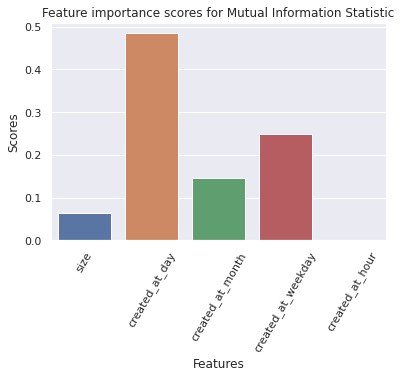

In [48]:
# visualize scores of all features
sns.barplot(x=X_inp.columns, y=fs.scores_)
plt.title("Feature importance scores for Mutual Information Statistic")
plt.xticks(rotation=60)
plt.xlabel("Features")
plt.ylabel("Scores")
plt.show()

In [49]:
# Lets get a list of the top 10 feature indices based on Mutual Info Stat feature scores
top_mis = fs.scores_.argsort()[-10:][::-1]

In [50]:
# rank using chi_sq
X_fs, fs = select_features(X_inp, y, chi2)

In [51]:
for i in range(len(fs.scores_)):
    print("Feature %s: %f" % (X_inp.columns[i], fs.scores_[i]))

Feature size: 20.316190
Feature created_at_day: 96.026446
Feature created_at_month: 8.225657
Feature created_at_weekday: 5.428692
Feature created_at_hour: 3.360000


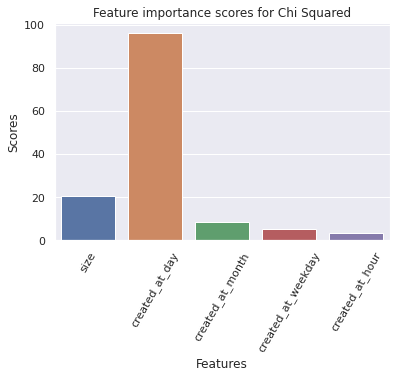

In [52]:
# visualize scores of all features
sns.barplot(x=X_inp.columns, y=fs.scores_)
plt.title("Feature importance scores for Chi Squared")
plt.xticks(rotation=60)
plt.xlabel("Features")
plt.ylabel("Scores")
plt.show()

In [53]:
# Lets get a list of the top 10 feature indices based on Chi Sq feature scores
top_chi2 = fs.scores_.argsort()[-10:][::-1]

Let's get a Union of the top 10 features derived from features based on both scores of both Mutual Info Statistic and Chi Squared

In [54]:
union = set(top_mis).union(set(top_chi2))
print(len(union))
union

5


{0, 1, 2, 3, 4}

In [55]:
selected_cat_features = [cat_features[i] for i in union]
selected_cat_features

['size',
 'created_at_day',
 'created_at_month',
 'created_at_weekday',
 'created_at_hour']

In [56]:
# update list of features to keep for training
selected_features += selected_cat_features

### Numerical Features

Now, lets try to determine what numerical featuers are powerful influencers for time to merge of a PR

In [57]:
numerical_features = [
    "changed_files_number",
    "body_size",
    "commits_number",
    "ttm_class",
]

In [58]:
numerical_df = feature_df[numerical_features]
numerical_df.head()

,changed_files_number,body_size,commits_number,ttm_class
0,1,1,1,8
1,1,22,1,5
2,2,25,1,9
3,1,18,2,7
4,1,12,12,7


In [59]:
# split into input features and target
X_inp = numerical_df.drop(columns=["ttm_class"])
y = numerical_df["ttm_class"]

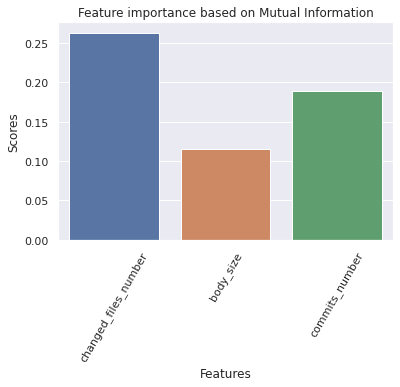

In [60]:
# create k best feature selector object based on mutual information
numerical_feats_mi, k_best_selector_mi = select_features(
    X_inp,
    y,
    partial(
        mutual_info_classif,
        discrete_features=False,
        random_state=42,
        n_neighbors=3,
    ),
)

# visualize the MI scores of all features
sns.barplot(x=X_inp.columns, y=k_best_selector_mi.scores_)
plt.title("Feature importance based on Mutual Information")
plt.xticks(rotation=60)
plt.xlabel("Features")
plt.ylabel("Scores")
plt.show()

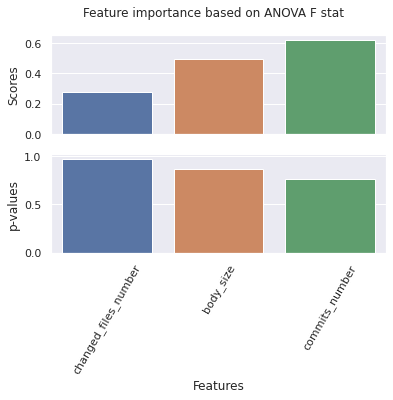

In [61]:
# create k best feature selector object based on anova f statistic
numerical_feats_f, k_best_selector_f = select_features(
    X_inp,
    y,
    f_classif,
)

# visualize the f stat scores and pvalues of all features
fig, axes = plt.subplots(2, 1, sharex=True)
fig.suptitle("Feature importance based on ANOVA F stat")
sns.barplot(x=X_inp.columns, y=k_best_selector_f.scores_, ax=axes[0])
sns.barplot(x=X_inp.columns, y=k_best_selector_f.pvalues_, ax=axes[1])
plt.xticks(rotation=60)
plt.xlabel("Features")
axes[0].set_ylabel("Scores")
axes[1].set_ylabel("p-values")
plt.show()

In [62]:
top_mi = k_best_selector_mi.scores_.argsort()[-3:][::-1]
top_anova = k_best_selector_f.scores_.argsort()[-3:][::-1]
union = set(top_mi).union(set(top_anova))
union

{0, 1, 2}

In [63]:
selected_num_features = [numerical_features[i] for i in union]
selected_num_features

['changed_files_number', 'body_size', 'commits_number']

In [64]:
# update list of features to keep for training
selected_features += selected_num_features

### Count Vector Type Features

Finally, lets determine the most important features from the count vector type columns.

In [65]:
# explode the list column so that there is 1 column representing frequency of each file type
filetype_df = pd.DataFrame(feature_df.changed_file_type_vec.to_list())
filetype_df.index = feature_df.index
filetype_df.columns = [f"filetype_{f}" for f in top_fileextensions]

In [66]:
# compute correlation with ttm
corr = filetype_df.corrwith(feature_df["ttm_class"])
corr.sort_values(ascending=False)

filetype_.md              0.362915
filetype_.txt             0.324655
filetype_.yaml            0.245993
filetype_LICENSE          0.196347
filetype_.ipynb           0.137848
filetype_.py              0.128369
filetype_Dockerfile      -0.084149
filetype_Containerfile   -0.140248
filetype_.yml            -0.177084
filetype_.sh             -0.413197
dtype: float64

In [67]:
corr[corr.abs() > 0.01]

filetype_.ipynb           0.137848
filetype_.yaml            0.245993
filetype_.py              0.128369
filetype_.yml            -0.177084
filetype_.sh             -0.413197
filetype_.md              0.362915
filetype_.txt             0.324655
filetype_LICENSE          0.196347
filetype_Dockerfile      -0.084149
filetype_Containerfile   -0.140248
dtype: float64

In [68]:
# update list of features to keep for training
# take everything that has more than 0.01 correlation magnitude
filetype_keep_cols = corr[corr.abs() > 0.01].index.tolist()
selected_features += filetype_keep_cols

# only keep the relevant columns now
filetype_df = filetype_df[filetype_keep_cols]

In [69]:
filetype_keep_cols = [i[9:] for i in filetype_keep_cols]
filetype_keep_cols

['.ipynb',
 '.yaml',
 '.py',
 '.yml',
 '.sh',
 '.md',
 '.txt',
 'LICENSE',
 'Dockerfile',
 'Containerfile']

In [70]:
filetype_keep_cols_df = pd.DataFrame(filetype_keep_cols, columns=["filetype"])

In [71]:
filetype_keep_cols_df

,filetype
0,.ipynb
1,.yaml
2,.py
3,.yml
4,.sh
5,.md
6,.txt
7,LICENSE
8,Dockerfile
9,Containerfile


In [72]:
FILETYPE_FEATURES_FILENAME = os.path.join(ORG + REPO + "FILETYPE.parquet")
FILETYPE_FEATURES_KEY = os.path.join(s3_input_data_path, ORG, REPO, "features")
cc.upload_to_ceph(
    filetype_keep_cols_df, FILETYPE_FEATURES_KEY, FILETYPE_FEATURES_FILENAME
)

{'ResponseMetadata': {'RequestId': '876ac92725dd8f5e',
  'HostId': 'aN6BmtGL+MqdmBDL0ZMA102SFN74yXDJd',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-request-id': '876ac92725dd8f5e',
   'x-amz-id-2': 'aN6BmtGL+MqdmBDL0ZMA102SFN74yXDJd',
   'etag': '"0062049ac0c429cdbae723cbced6bc94"',
   'x-amz-version-id': '4_z578ffb122f12ad158d570212_f117e80948174c1a3_d20230203_m125834_c000_v0001082_t0029_u01675429114638',
   'cache-control': 'max-age=0, no-cache, no-store',
   'content-length': '0',
   'date': 'Fri, 03 Feb 2023 12:58:34 GMT'},
  'RetryAttempts': 0},
 'ETag': '"0062049ac0c429cdbae723cbced6bc94"',
 'VersionId': '4_z578ffb122f12ad158d570212_f117e80948174c1a3_d20230203_m125834_c000_v0001082_t0029_u01675429114638'}

In [73]:
# explode the list column so that there is 1 column representing frequency of each word
title_wordcount_df = pd.DataFrame(feature_df.title_word_counts_vec.to_list())

title_wordcount_df.index = feature_df.index
title_wordcount_df.columns = [f"title_wordcount_{w}" for w in unique_words]

In [74]:
# compute correlation with ttm
corr = title_wordcount_df.corrwith(feature_df["ttm_class"])
corr = corr.dropna()
corr.sort_values(ascending=False)

title_wordcount_pr               0.336032
title_wordcount_functionality    0.282267
title_wordcount_workflow         0.282267
title_wordcount_srcopsmetrics    0.196347
title_wordcount_sample           0.196347
                                   ...   
title_wordcount_prs             -0.308546
title_wordcount_condition       -0.308546
title_wordcount_train           -0.308546
title_wordcount_size            -0.308546
title_wordcount_fixed           -0.308546
Length: 70, dtype: float64

In [75]:
corr[corr.abs() > 0.04]

title_wordcount_action          -0.040324
title_wordcount_add              0.177084
title_wordcount_adding           0.140248
title_wordcount_api              0.147570
title_wordcount_basic           -0.140248
title_wordcount_best            -0.196347
title_wordcount_branding         0.140248
title_wordcount_callingprs      -0.252447
title_wordcount_changed          0.196347
title_wordcount_choose          -0.196347
title_wordcount_clean           -0.196347
title_wordcount_cleanup         -0.084149
title_wordcount_comment          0.084149
title_wordcount_condition       -0.308546
title_wordcount_data             0.196347
title_wordcount_docs             0.196347
title_wordcount_documentation    0.120972
title_wordcount_download         0.196347
title_wordcount_engineering     -0.196347
title_wordcount_entrypoint      -0.236113
title_wordcount_error            0.196347
title_wordcount_feature         -0.196347
title_wordcount_fix             -0.201619
title_wordcount_fixed           -0

In [76]:
# update list of features to keep for training
# take everything that has more than 0.01 correlation magnitude
title_word_keep_cols = corr[corr.abs() > 0.04].index.tolist()
selected_features += title_word_keep_cols

title_wordcount_df = title_wordcount_df[title_word_keep_cols]

In [77]:
title_word_keep_cols = [i[16:] for i in title_word_keep_cols]
title_word_keep_cols

['action',
 'add',
 'adding',
 'api',
 'basic',
 'best',
 'branding',
 'callingprs',
 'changed',
 'choose',
 'clean',
 'cleanup',
 'comment',
 'condition',
 'data',
 'docs',
 'documentation',
 'download',
 'engineering',
 'entrypoint',
 'error',
 'feature',
 'fix',
 'fixed',
 'functionality',
 'github',
 'improve',
 'inputs',
 'merge',
 'messaging',
 'mode',
 'model',
 'modes',
 'notebook',
 'notebook3',
 'optimization',
 'pr',
 'pre',
 'prs',
 'publishing',
 'pygithub',
 'rate',
 'refactored',
 'sample',
 'sh',
 'size',
 'srcopsmetrics',
 'test',
 'testing',
 'train',
 'training',
 'trigger',
 'update',
 'updates',
 'upstream',
 'use',
 'workflow',
 'yml']

In [78]:
title_word_keep_cols_df = pd.DataFrame(title_word_keep_cols, columns=["title"])

In [79]:
title_word_keep_cols_df

,title
0,action
1,add
2,adding
3,api
4,basic
5,best
6,branding
7,callingprs
8,changed
9,choose


In [80]:
TITLE_FEATURES_FILENAME = os.path.join(ORG + REPO + "titlewords.parquet")
TITLE_FEATURES_KEY = os.path.join(s3_input_data_path, ORG, REPO, "features")
cc.upload_to_ceph(title_word_keep_cols_df, TITLE_FEATURES_KEY, TITLE_FEATURES_FILENAME)

{'ResponseMetadata': {'RequestId': '6f2ced38426ef2c2',
  'HostId': 'aN65m5WL4MsBmRDJYZCw1SGSLN9Qy6zJF',
  'HTTPStatusCode': 200,
  'HTTPHeaders': {'x-amz-request-id': '6f2ced38426ef2c2',
   'x-amz-id-2': 'aN65m5WL4MsBmRDJYZCw1SGSLN9Qy6zJF',
   'etag': '"c7264f9d7df19f349ae1c62b600415af"',
   'x-amz-version-id': '4_z578ffb122f12ad158d570212_f117e205eef95c147_d20230203_m125835_c000_v0001060_t0052_u01675429115705',
   'cache-control': 'max-age=0, no-cache, no-store',
   'content-length': '0',
   'date': 'Fri, 03 Feb 2023 12:58:35 GMT'},
  'RetryAttempts': 0},
 'ETag': '"c7264f9d7df19f349ae1c62b600415af"',
 'VersionId': '4_z578ffb122f12ad158d570212_f117e205eef95c147_d20230203_m125835_c000_v0001060_t0052_u01675429115705'}

Using various feature importance scores such as chi-squared, mutual information statistic, correlation values, we have selected the most relevant features amongst all of our features. 

In [81]:
selected_features

['size',
 'created_at_day',
 'created_at_month',
 'created_at_weekday',
 'created_at_hour',
 'changed_files_number',
 'body_size',
 'commits_number',
 'filetype_.ipynb',
 'filetype_.yaml',
 'filetype_.py',
 'filetype_.yml',
 'filetype_.sh',
 'filetype_.md',
 'filetype_.txt',
 'filetype_LICENSE',
 'filetype_Dockerfile',
 'filetype_Containerfile',
 'title_wordcount_action',
 'title_wordcount_add',
 'title_wordcount_adding',
 'title_wordcount_api',
 'title_wordcount_basic',
 'title_wordcount_best',
 'title_wordcount_branding',
 'title_wordcount_callingprs',
 'title_wordcount_changed',
 'title_wordcount_choose',
 'title_wordcount_clean',
 'title_wordcount_cleanup',
 'title_wordcount_comment',
 'title_wordcount_condition',
 'title_wordcount_data',
 'title_wordcount_docs',
 'title_wordcount_documentation',
 'title_wordcount_download',
 'title_wordcount_engineering',
 'title_wordcount_entrypoint',
 'title_wordcount_error',
 'title_wordcount_feature',
 'title_wordcount_fix',
 'title_wordcount_

## Save Feature Engineered Dataset

In [82]:
# join all types of features
ttm_dataset = pd.concat(
    [feature_df, filetype_df, title_wordcount_df], axis=1, ignore_index=False
)

# keep only the selected features and the prediction label
ttm_dataset = ttm_dataset[selected_features + ["ttm_class", "time_to_merge"]]

ttm_dataset.head()

,size,created_at_day,created_at_month,created_at_weekday,created_at_hour,changed_files_number,body_size,commits_number,filetype_.ipynb,filetype_.yaml,...,title_wordcount_training,title_wordcount_trigger,title_wordcount_update,title_wordcount_updates,title_wordcount_upstream,title_wordcount_use,title_wordcount_workflow,title_wordcount_yml,ttm_class,time_to_merge
0,0,27,1,4,19,1,1,1,0,0,...,0,0,0,0,0,0,0,0,8,242379.0
1,2,27,1,4,16,1,22,1,1,0,...,0,0,0,0,0,0,0,0,5,8554.0
2,3,12,1,3,19,2,25,1,1,0,...,0,0,0,0,0,0,0,0,9,502425.0
3,2,10,1,1,19,1,18,2,0,0,...,0,0,0,0,0,0,0,0,7,87972.0
4,2,8,12,3,19,1,12,12,0,0,...,0,0,0,1,0,0,0,0,7,88801.0


In [83]:
ttm_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 32 entries, 0 to 31
Data columns (total 78 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   size                           32 non-null     int64  
 1   created_at_day                 32 non-null     int64  
 2   created_at_month               32 non-null     int64  
 3   created_at_weekday             32 non-null     int64  
 4   created_at_hour                32 non-null     int64  
 5   changed_files_number           32 non-null     int64  
 6   body_size                      32 non-null     int64  
 7   commits_number                 32 non-null     int64  
 8   filetype_.ipynb                32 non-null     int64  
 9   filetype_.yaml                 32 non-null     int64  
 10  filetype_.py                   32 non-null     int64  
 11  filetype_.yml                  32 non-null     int64  
 12  filetype_.sh                   32 non-null     int64

## Save results to Ceph or locally

Using the helper function to save the data frame in a parquet format on the Ceph bucket if we are running in automation, and locally if not.

In [84]:
TTM_DATASET_PATH = os.path.join(s3_input_data_path, ORG, REPO)

In [85]:
## Sanity check to see if the dataset is the same

try:
    cc.upload_to_ceph(
        ttm_dataset,
        TTM_DATASET_PATH,
        "ttm_feature_engineered_dataset.parquet",
    )
except ValueError as ve:
    print(ve)
    print("Files already uploaded to S3")

# Conclusion

This notebook walked through how to access saved raw Pull Requests data from the previous data collection notebook and we engineered some possible features which can be used to predict time to merge of a PR. 

The features we engineered are as following:

- time_to_merge: time taken to merge a PR in seconds, this is feature we will try to predict
- changed_files_number: integer indicating the number of files changed, this is an available column
- body_size: integer indicating the number of words in the body of the PR, derived from body
- size: integer corresponding to a categorical label generated by GitHub which summarizes the size of the changes made to the code base 
- title_word_counts_vec: vector or list indicating how many times each word appeared in the title
- created_at_day: categorical variable indicating the day of month the PR has been created, derived from created_at
- created_at_month: categorical variable indicating the month of the year that the PR has been created, derived from created_at
- created_at_weekday: categorical variable indicating the day of the week the PR has been created, derived from created_at
- created_at_hour: categorical variable indicating the hour of the day the PR has been created, derived from created_at
- commits_number: integer indicating the number of commits in the PR
- changed_file_type_vec:  vector or list consisting of number of files changed for the top 100 most frequently occurring data types, derived from changed_files


# Next Step

In the next [notebook](./03_model_training.ipynb), we will train a classifier to predict time to merge of a PR using the features.